In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [2]:
proc_data = pd.read_pickle('data/exp3_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(proc_data, training_contexts=3, binom=False)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
print len(list(set(proc_data.subj)))

100%|██████████| 196/196 [00:51<00:00,  4.25it/s]


N clusters = 2, Covarainace = diag
129


# Analyses

In [3]:
uids = list(set(proc_data.subj))
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 4

The simplest test is a comparison to chance in goal accuracy

In [4]:
from scipy.stats import ttest_1samp

acc = proc_data[proc_data['In Goal']].groupby(['Training','subj']).mean().loc[True, 'Accuracy']
t, p = ttest_1samp(acc, 0.5)
print "Mean: {}, t({})={}; p(one-sided)<{}".format(np.mean(acc), len(acc)-1, t, p/2)

Mean: 0.820009689922, t(128)=26.7734844714; p(one-sided)<1.34923282608e-54


In [5]:
acc = proc_data[proc_data['In Goal']].groupby(['Training','subj']).mean().loc[False, 'Accuracy']
t, p = ttest_1samp(acc, 0.5)
print "Mean: {}, t({})={}; p(one-sided)<{}".format(np.mean(acc), len(acc)-1, t, p/2)

Mean: 0.80765503876, t(128)=21.8606369196; p(one-sided)<2.42914077593e-45


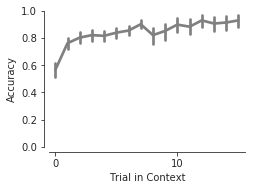

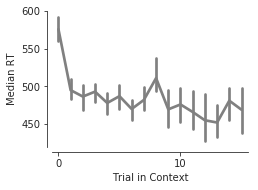

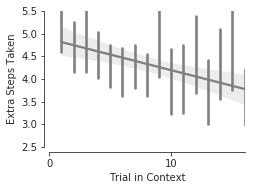

In [6]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)

In [7]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.154622,0.014424,0.000593,0.127324,0.184221,527.691770,1.003137
beta_reps,0.652268,0.094464,0.002568,0.474225,0.841212,1541.335926,0.999640


In [8]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample()
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.015592,0.003689,0.000126,0.008714,0.022849,731.971420,0.99923
beta_reps,0.045094,0.032403,0.000973,-0.022461,0.104848,1127.296145,0.99934


In [9]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:

    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps',  mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    
    # inference
    trace_steps = pm.sample()
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,-0.011811,0.001887,0.000055,-0.01576,-0.008442,1044.221269,1.000171
beta_reps,-0.194365,0.016330,0.000518,-0.22705,-0.164861,917.191177,0.999255


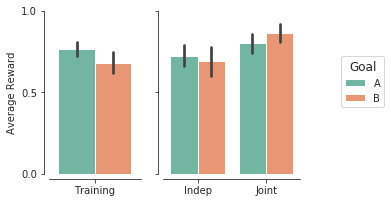

In [10]:
from matplotlib import gridspec
with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(4.5, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5], wspace=0.2)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]))
    cc = sns.color_palette('Set2')
    
    df0 = proc_data[proc_data['In Goal'] & (proc_data.Context <= 3) & 
                    (proc_data['Times Seen Context'] <= 4)].copy()
    df0['Goal'] = ['A'] * len(df0)
    df0.loc[df0.Context == 3, 'Goal'] = 'B'
    df0['Task'] = ['Training'] * len(df0)
    sns.barplot(hue='Goal', y='Accuracy', data=df0, ax=axes[0],  units='subj', palette=cc,
                x='Task', hue_order=['A', 'B'])
    
    df0 = proc_data[proc_data['In Goal'] & (proc_data.Context > 3) &
                    (proc_data['Times Seen Context'] <= 4)].copy()
    df0.loc[df0.Task == 'A', 'Task'] = 'Indep'
    df0.loc[df0.Task == 'B', 'Task'] = 'Joint'
    df0['Goal'] = ['A'] * len(df0)
    df0.loc[df0.Context == 6, 'Goal'] = 'B'
    sns.barplot(hue='Goal', y='Accuracy', data=df0, ax=axes[1], order=['Indep', 'Joint'],
                x='Task', units='subj', palette='Set2', hue_order=['A', 'B'])
    
    for ax in axes:
        ax.set_ylabel('')
        ax.set_ylim([0, 1])
        ax.set_yticks([0, 0.5, 1])
    
    ax = axes[0]
    ax.set_ylabel('Average Reward')
    ax.get_legend().set_visible(False)

    ax = axes[1]
    ax.set_yticklabels('')
    ax.get_legend().set_visible(False)
    ax.legend(bbox_to_anchor = [1.65, 0.75], title="Goal")
    ax.get_legend().get_title().set_fontsize(12)
    ax.get_legend().get_title().set_multialignment('center')
    
    for ax in axes:
        ax.set_xlabel(' ')

    sns.despine(offset=5)


/Users/nicholasfranklin/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/nicholasfranklin/anaconda3/envs/compgen/lib/python2.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


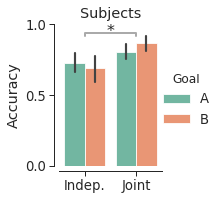

In [11]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style('ticks'):
    g = sns.factorplot(
        hue='Goal', y='Accuracy', data=df0, kind='bar',  order=['Indep', 'Joint'],
        hue_order=['A', 'B'],
        x='Task', units='subj', 
        palette='Set2', size=3.0, aspect=0.85
    )
    sns.despine(offset=5)
    
    g.set_xticklabels('Indep. Joint'.split())
    g.set_xlabels('')
    g.set_ylabels('Accuracy')
    g.axes[0][0].set_yticks(np.arange(0, 1.01, 0.5))
    g.axes[0][0].set_ylim(0, 1)
    
    g.axes[0][0].set_title('Subjects')

    ax = plt.gca()
    ax.text(0.5, 0.95, "*", size=16, horizontalalignment='center', verticalalignment='center')

    ax.annotate("", xy=(0, 0.90), xycoords='data', xytext=(1, 0.90), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.1"))

#     plt.savefig('exp_2_goals_behav.png', dpi=300, bbox_inches='tight')
    

In [12]:
mu = proc_data[proc_data['In Goal']].groupby('subj').mean().mean()['Accuracy']
sd = proc_data[proc_data['In Goal']].groupby('subj').mean().std()['Accuracy']
print mu, sd

0.8158914728682173 0.11686270666772218


In [13]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context'] <= 4) &
              (proc_data['Context'] >= 4)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')

# predictors of interest
x_gA = np.array((X0.Context == 4) | (X0.Context == 5), dtype='int') - \
    np.array(X0.Context == 6, dtype='int')
x_tA = np.array(X0.Task == 'A', dtype='int') - np.array(X0.Task == 'B', dtype='int')
    
# nuissance
x_ti = X0['Times Seen Context'].values
x_ti -= x_ti.mean()
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_gA = pm.Normal('beta_goalA', mu=0., sd=100)
    b_tA = pm.Normal('beta_taskA', mu=0., sd=100)
    b_ti = pm.Normal('beta_times', mu=0., sd=100)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_gA * x_gA + b_tA * x_tA +
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    
    # inference
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times, beta_taskA, beta_goalA]
The number of effective samples is smaller than 25% for some parameters.


In [14]:
pm.stats.summary(trace, varnames=['beta_goalA', 'beta_taskA','beta_times','beta_reps'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_goalA,0.006151,0.074209,0.001066,-0.135284,0.152458,4432.036770,0.999881
beta_taskA,-0.408544,0.133097,0.002884,-0.672570,-0.156665,1967.074185,0.999972
beta_times,0.343291,0.063634,0.000989,0.207344,0.460436,4082.320517,0.999923
beta_reps,1.633055,0.316178,0.005228,1.030625,2.241641,3836.595468,1.000511


In [15]:
summary = pm.stats.summary(trace, varnames=['beta_goalA', 'beta_taskA','beta_times','beta_reps'])

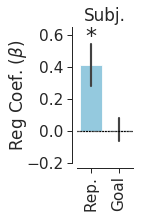

In [16]:
sns.set_context('paper', font_scale=1.75)


betas = pd.DataFrame({
        'Goal': trace['beta_goalA'],
        'Repeat': -trace['beta_taskA'],
    })

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(1, 1, figsize=(1.0, 2.5))   

    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
                color='skyblue', ci='sd', order=['Repeat', 'Goal',])
    sns.despine(offset=5)

#     ax.plot([-1, 2], [0, 0], 'k:')
#     ax.set_yticks([-0.4, -.2, 0, 0.2, 0.4])
    ax.set_xlabel('')
    
    ax.set_ylabel(r'Reg Coef. ($\beta$)', labelpad=-3)
    ax.set_xlabel('')
    ax.plot([-1, 2], [0, 0], 'k:')
    ax.set_xlim([-0.5, 1.5])
    ax.set_yticks(np.arange(-0.2, 0.7, 0.2))
    ax.set_ylim([-0.2, 0.65])
    sns.despine(offset=5)
    plt.xticks([0, 1], ['Rep.', 'Goal'], rotation='vertical')


    
        
    plt.axhline(y=0, c='k', ls=':')
#     plt.title('Subj.')
    ax.set_title('Subj.')
#     ax.set_ylabel(r'Reg Coef. ($\beta$)')#, labelpad=)#, fontdict={'size': 16})#, 'weight': 'bold'})
#     plt.xlabel("")
    
    def plot_stars(x0):
        ax.annotate("*", xy=(x0-0.175, 0.55), size=22)

    # plot the error bars
#     ax.plot([0, 0],[mu_task-sd_task, mu_task+sd_task], 'k', lw=2)

    if np.sign(summary.loc['beta_goalA', 'hpd_2.5'] ) == \
        np.sign(summary.loc['beta_goalA', 'hpd_97.5'] ):
        plot_stars(1)

#     ax.plot([1, 1],[mu_goal-sd_goal, mu_goal+sd_goal], 'k', lw=2)
    
    if np.sign(summary.loc['beta_taskA', 'hpd_2.5'] ) == \
        np.sign(summary.loc['beta_taskA', 'hpd_97.5'] ):
        plot_stars(0)

#

plt.savefig('exp_2_goals_behav.png', dpi=300, bbox_inches='tight')

In [17]:
print np.mean(trace['beta_taskA'] < 0)

0.9995


In [18]:
len(set(proc_data.loc[proc_data['Task'] == 'A', 'subj']))

49

In [19]:
len(set(proc_data.loc[proc_data['Task'] == 'B', 'subj']))

80

In [20]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context'] <= 4) &
              (proc_data['Context'] >= 4)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')

# predictors of interest
x_gA = np.array((X0.Context == 4) | (X0.Context == 5), dtype='int') - \
    np.array(X0.Context == 6, dtype='int')
x_tA = np.array(X0.Task == 'A', dtype='int') - np.array(X0.Task == 'B', dtype='int')
    
# nuissance
x_ti = X0['Times Seen Context'].values
x_ti -= x_ti.mean()
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_null:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    
    # inference
    trace_null = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times]


In [21]:
df_comp_LOO = pm.compare((trace, trace_null),
                          (glm, glm_null), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Full', 'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

TypeError: compare() got multiple values for keyword argument 'ic'